Here, we'll try to fit our very first model on TennisExplorer data

In [1]:
from tennis_new.fetch.tennis_explorer.combiner import read_joined

jd = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [47]:
jd[jd['surface'].isnull()].iloc[-1]

comment                                      NaN
date                                  2020-01-25
match_link             /match-detail/?id=1867589
match_time                                 08:30
p1_link                           /player/zekic/
p1_name                                 Zekic M.
p1_odds                                     1.36
p1_seed                                      NaN
p1_set1                                        7
p1_set2                                        6
p1_set3                                      NaN
p1_set4                                      NaN
p1_set5                                      NaN
p1_sets_won                                    2
p2_link                         /player/eleveld/
p2_name                               Eleveld J.
p2_odds                                     2.96
p2_seed                                      NaN
p2_set1                                        6
p2_set2                                        0
p2_set3             

In [2]:
from tennis_new.model.utils.filters import (
    MissingPIDFilter,
    MissingScoreFilter,
    PossibleWalkoverFilter,
    RetirementFilter,
    TrainingFilter
)

#### Back to Fitting

In [7]:
# Fit only when we have the unique identifier for both players?
rel = TrainingFilter.filter(jd)

In [8]:
from tennis_new.ml.elo import ELOModel

match_elo = ELOModel(winner_mod=True)

In [9]:
%pdb
match_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link']
)

Automatic pdb calling has been turned OFF


In [44]:
import pandas as pd

def get_test_set(df, test_min='2011-01-01', test_max='2015-01-01', test_surface=None, filter_walkovers=True):
    date_cond = (
        (df['date'] >= test_min) &
        (df['date'] < test_max)
    )
    if test_surface is None:
        surface_cond = True
    cond = date_cond & surface_cond
    if filter_walkovers:
        cond &= (~possible_walkover(df))
    return df[cond]

def eval_mod(mod, df, test_min='2011-01-01', test_max='2015-01-01', test_surface=None, filter_walkovers=False):
    # TODO: Filter out walkovers from test set
    history_df = pd.DataFrame(mod.history)
    test_set = get_test_set(
        df,
        test_min=test_min,
        test_max=test_max,
        test_surface=test_surface,
        filter_walkovers=filter_walkovers
    )
    test_set = pd.merge(test_set, history_df, left_on='match_link', right_on='match_id')
    
    accuracy = (test_set['elo_match_prediction'] > 0.5).mean()
    w_odds = test_set[
        test_set['p1_odds'].notnull() &
        test_set['p2_odds'].notnull() &
        (test_set['p1_odds'] != test_set['p2_odds'])
    ]
    n_w_odds = w_odds.shape[0]
    odds_accuracy = (w_odds['p1_odds'] <= w_odds['p2_odds']).mean()
    mod_odds_accuracy = (w_odds['elo_match_prediction'] > 0.5).mean()
    return {
        'overall_accuracy': accuracy,
        'odds_accuracy': odds_accuracy,
        'model_odds_accuracy': mod_odds_accuracy,
        'n_w_odds': n_w_odds
    }

In [45]:
match_eval = eval_mod(match_elo, rel)
match_eval

{'overall_accuracy': 0.7275996830794705,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7074658387051017,
 'n_w_odds': 63449}

#### Try Initial Set Model

Note that this model we will definitely have to tune the ELO parameters.

In [13]:
from tennis_new.ml.elo import ELOModel

set_elo = ELOModel(winner_mod=True)

In [14]:
set_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link'],
    ys=rel[['p1_sets_won', 'p2_sets_won']].values
)

In [37]:
set_eval = eval_mod(set_elo, rel)
set_eval

224662


{'overall_accuracy': 0.7358520800135314,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7080332235338619,
 'n_w_odds': 63449}

The set model is working pretty well!  We should tune the ELO parameters again

This is even worse!  For now, we won't do any filtering

#### Tune ELO Parameters

In [17]:
from tennis_new.ml.sobol import generate_sobol_seq, get_range_values

MIN_C = 100
MAX_C = 500
MIN_O = 0
MAX_O = 50
MIN_S = 0
MAX_S = 2


sobol_vals = generate_sobol_seq(3, 100, 1)
cs = get_range_values(MIN_C, MAX_C, sobol_vals[:, 0])
os = get_range_values(MIN_O, MAX_O, sobol_vals[:, 1])
ss = get_range_values(MIN_S, MAX_S, sobol_vals[:, 2])

In [18]:
from tqdm.autonotebook import tqdm

out = []
test_out = []
for c, o, s in tqdm(zip(cs, os, ss)):
    cur_elo = ELOModel(c=c, o=o, s=s, winner_mod=True)
    cur_elo.fit_and_backfill(
        rel['p1_link'],
        rel['p2_link'],
        rel['match_link'],
        ys=rel[['p1_sets_won', 'p2_sets_won']].values
    )
    cur_eval = eval_mod(cur_elo, rel)
    test_eval = eval_mod(cur_elo, rel, test_min='2015-01-01', test_max='2021-01-01')
    cur_eval.update({'c': c, 'o': o, 's': s})
    test_eval.update({'c': c, 'o': o, 's': s})
    out.append(cur_eval)
    test_out.append(test_eval)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662
282149
224662

In [19]:
tune_df = pd.DataFrame(out)

In [20]:
test_df = pd.DataFrame(test_out)

In [23]:
tune_df.sort_values('model_odds_accuracy', ascending=False).head()

,c,model_odds_accuracy,n_w_odds,o,odds_accuracy,overall_accuracy,s
66,209.375,0.708380,63449,32.421875,0.720043,0.734730,0.390625
35,268.750,0.708254,63449,7.031250,0.720043,0.733106,0.468750
46,143.750,0.708128,63449,35.156250,0.720043,0.732848,0.343750
77,334.375,0.708033,63449,4.296875,0.720043,0.732029,0.515625
25,462.500,0.707923,63449,20.312500,0.720043,0.733417,0.562500


In [38]:
(tune_df['model_odds_accuracy'] > set_eval['model_odds_accuracy']).mean()

0.03

In [39]:
test_df.sort_values('model_odds_accuracy', ascending=False, inplace=True)
test_df.head()

,c,model_odds_accuracy,n_w_odds,o,odds_accuracy,overall_accuracy,s
35,268.750,0.716535,166130,7.031250,0.726046,0.731323,0.468750
66,209.375,0.716367,166130,32.421875,0.726046,0.731628,0.390625
46,143.750,0.716216,166130,35.156250,0.726046,0.730210,0.343750
22,187.500,0.716180,166130,42.187500,0.726046,0.727974,0.437500
25,462.500,0.716180,166130,20.312500,0.726046,0.731188,0.562500


In [40]:
test_eval = eval_mod(set_elo, rel, test_min='2015-01-01', test_max='2021-01-01')
(test_df['model_odds_accuracy'] > test_eval['model_odds_accuracy']).mean()

282149


0.08

In [29]:
from scipy.stats import spearmanr

(
    spearmanr(tune_df['model_odds_accuracy'], test_df['model_odds_accuracy']),
    spearmanr(tune_df['overall_accuracy'], test_df['overall_accuracy'])
)

(SpearmanrResult(correlation=-0.01588963663264467, pvalue=0.875316933156026),
 SpearmanrResult(correlation=-0.03675967596759676, pvalue=0.7165317400859508))

Above, it loks like the 

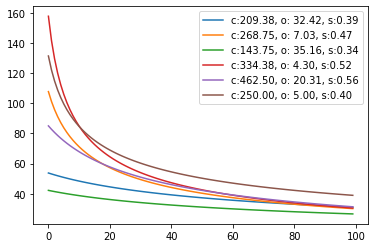

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def _plot_params(c, o, s):
    _x = np.arange(100)
    _y = c / (_x + o) ** s
    plt.plot(_x, _y, label='c:%0.2f, o: %0.2f, s:%0.2f' % (c, o, s))
        

def _plot_row(row):
    _plot_params(row['c'], row['o'], row['s'])

for i in range(5):
    _plot_row(tune_df.sort_values('model_odds_accuracy', ascending=False).iloc[i])

_default_mod = ELOModel()
_plot_params(_default_mod.c, _default_mod.o, _default_mod.s)

plt.legend()

Above, it looks like the default parameters (those suggested by ESPN) are almost as good as what we've found through tuning.